In [1]:
%load_ext autoreload
%autoreload 2

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models
import random

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from main.seir.sensitivity import calculate_sensitivity_and_plot
import main.seir.uncertainty as uncertainty_module
from utils.generic.create_report import save_dict_and_create_report_simple
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles
from main.seir.recovery import loss_parameter_recovery, get_top_k_with_recovery_loss

import yaml

In [26]:
predictions_dict = {}

In [72]:
config_filename = 'default.yaml'
config = read_config(config_filename)

In [28]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S"))

## Perform M1 and M2 fits

0 0 46
Performing m1 fit ..
{}
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 39                  | 40                  | 41                  | 42                  | 43                  |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-09-26 00:00:00 | 2020-09-27 00:00:00 | 2020-09-28 00:00:00 | 2020-09-29 00:00:00 | 2020-09-30 00:00:00 |
| active      | 33618.0             | 33152.43            | 32691.0             | 32212.0             | 31730.0             |
| total       | 200573.57           | 201638.86           | 202731.0            | 203739.0            | 204722.0            |
| recovered   | 154687.43           | 156098.14           | 157530.0            | 158900.0            | 160249.0            |
| deceased    | 12268.14            | 12388.

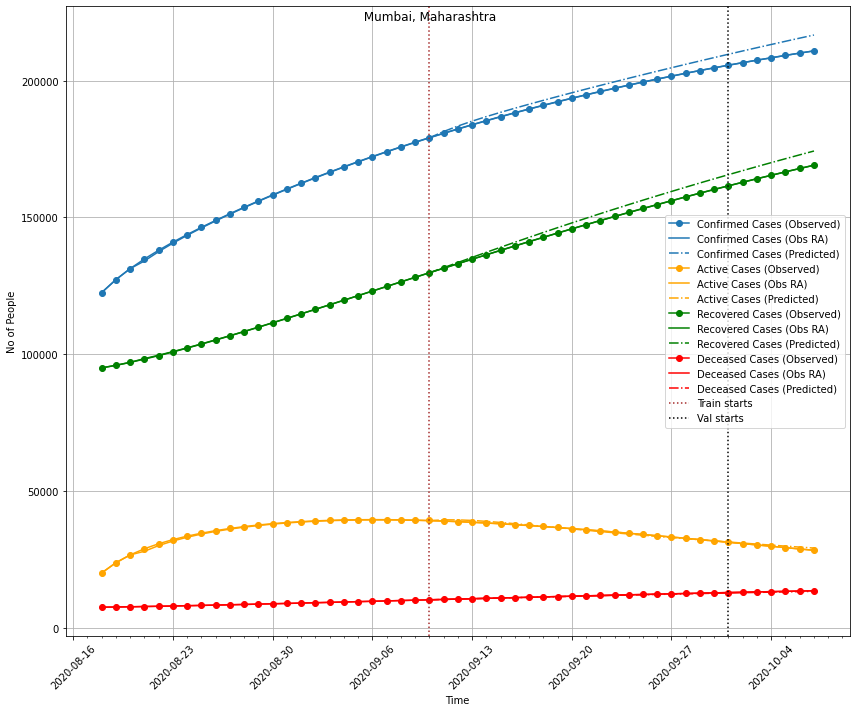

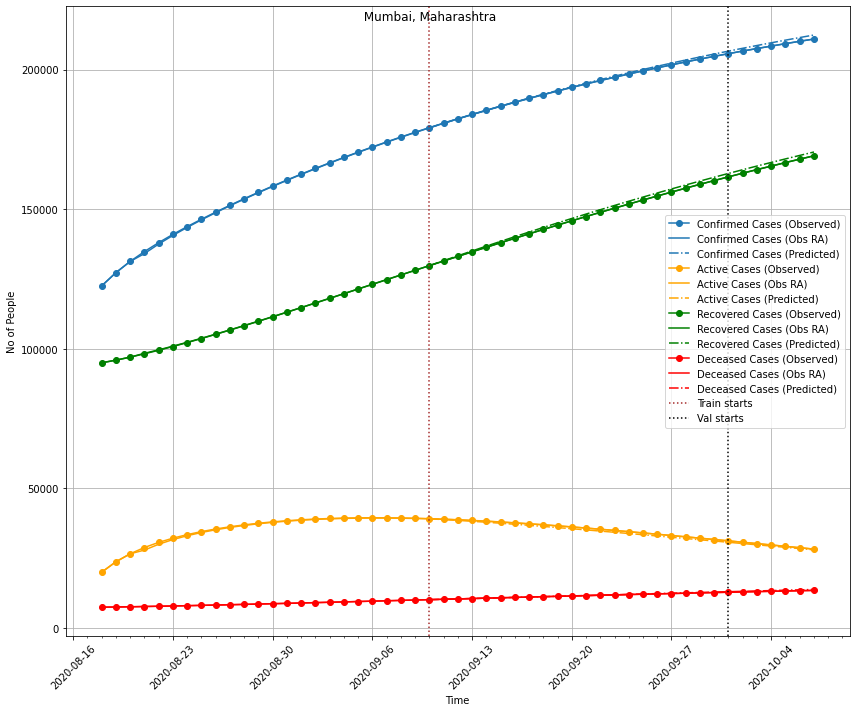

In [41]:
best_params = []
ideal_params = []
train_losses = []
val_losses = []
n, m = 2, 1
for j in range(m):
    r = random.randint(1,100)
    for i in range(n):
        print (j, i, r)
        np.random.seed(r)
        predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting'])) 
        predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")
        best_params.append(predictions_dict['m1']['best_params'])
        ideal_params.append(predictions_dict['m1']['ideal_params'])
        train_losses.append(predictions_dict['m1']['df_loss']['train'])
        val_losses.append(predictions_dict['m1']['df_loss']['val'])

In [62]:
loss_parameter_recovery(best_params, ideal_params, params=['P_fatal', 'T_inc', 'T_inf', 'T_recov', 'T_recov_fatal', 'lockdown_R0'], loss_function='rmse_log')

{&#39;E_hosp_ratio&#39;: 0.8047708880356589,
 &#39;I_hosp_ratio&#39;: 1.6599464785350273,
 &#39;P_fatal&#39;: 0.27551123159741187,
 &#39;T_inc&#39;: 0.13226581120283495,
 &#39;T_inf&#39;: 0.04262985062103978,
 &#39;T_recov&#39;: 0.09299690664995815,
 &#39;T_recov_fatal&#39;: 0.27935616891965226,
 &#39;lockdown_R0&#39;: 0.11093365620337567}

# Top k trials - recovery

Performing m1 fit ..
{&#39;lockdown_R0&#39;: 0.8, &#39;T_inc&#39;: 5.1, &#39;T_inf&#39;: 3.6, &#39;T_recov&#39;: 21.5, &#39;T_recov_fatal&#39;: 25.5, &#39;P_fatal&#39;: 0.08, &#39;E_hosp_ratio&#39;: 0.34, &#39;I_hosp_ratio&#39;: 0.94}
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 39                  | 40                  | 41                  | 42                  | 43                  |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-09-26 00:00:00 | 2020-09-27 00:00:00 | 2020-09-28 00:00:00 | 2020-09-29 00:00:00 | 2020-09-30 00:00:00 |
| active      | 33618.0             | 33152.43            | 32691.0             | 32212.0             | 31730.0             |
| total       | 200573.57           | 201638.86           | 202731.0            | 203739.0  

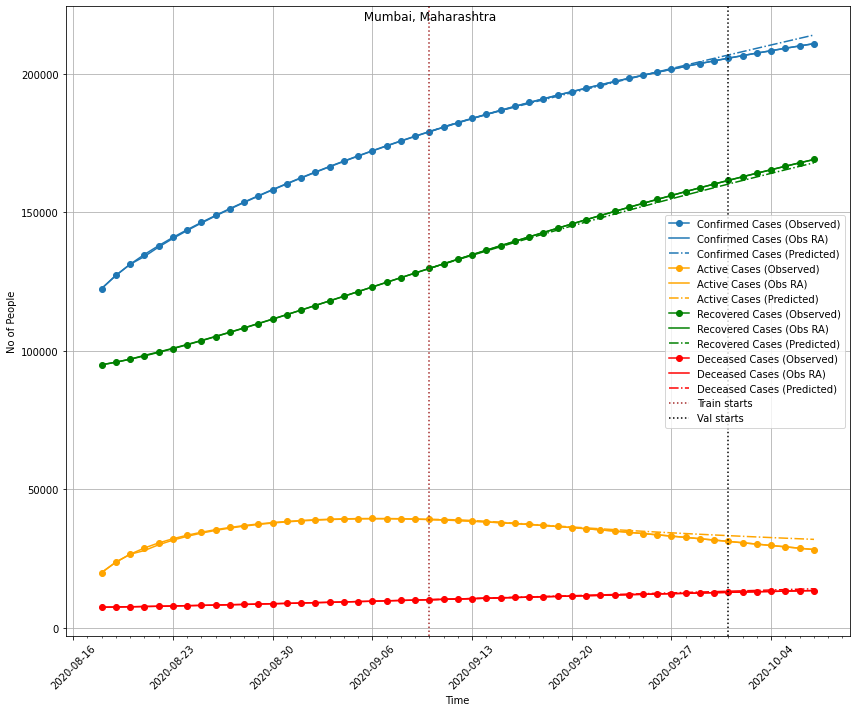

In [74]:
prediction_dict = {}
predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting'])) 

In [75]:
predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

12it [00:00, 116.83it/s]getting forecasts ..
1000it [00:08, 120.58it/s]


In [77]:
get_top_k_with_recovery_loss(predictions_dict)

[0.86480103 0.86623166 1.01713377 1.16175182 1.23830094 1.24587987
 1.51585586 1.51789581 1.5191272  1.51950658] [{&#39;E_hosp_ratio&#39;: 0.14844489033546077, &#39;I_hosp_ratio&#39;: 0.16113218863457826, &#39;P_fatal&#39;: 0.12223329340334106, &#39;T_inc&#39;: 5.949766908091115, &#39;T_inf&#39;: 3.3404725936114463, &#39;T_recov&#39;: 21.578048299672133, &#39;T_recov_fatal&#39;: 34.55327774476753, &#39;lockdown_R0&#39;: 0.9867831842521014}
 {&#39;E_hosp_ratio&#39;: 0.07797274083268402, &#39;I_hosp_ratio&#39;: 0.2005852813189684, &#39;P_fatal&#39;: 0.11993567717822433, &#39;T_inc&#39;: 5.802477728234475, &#39;T_inf&#39;: 3.352511910114195, &#39;T_recov&#39;: 22.16687563661591, &#39;T_recov_fatal&#39;: 33.71574430398797, &#39;lockdown_R0&#39;: 0.9547096335428857}
 {&#39;E_hosp_ratio&#39;: 0.07205143242878104, &#39;I_hosp_ratio&#39;: 0.17079972676409236, &#39;P_fatal&#39;: 0.11520791446647684, &#39;T_inc&#39;: 5.748227218184362, &#39;T_inf&#39;: 3.455129379539491, &#39;T_recov&#39;: 24.18

,params,fitting loss,recovery loss
0,"{'E_hosp_ratio': 0.14844489033546077, 'I_hosp_...",0.864801,0.719607
1,"{'E_hosp_ratio': 0.07797274083268402, 'I_hosp_...",0.866232,0.778645
2,"{'E_hosp_ratio': 0.07205143242878104, 'I_hosp_...",1.017134,0.835509
3,"{'E_hosp_ratio': 0.12285993698383166, 'I_hosp_...",1.161752,0.733172
4,"{'E_hosp_ratio': 0.17184433585200673, 'I_hosp_...",1.238301,0.689000
5,"{'E_hosp_ratio': 0.20645085926598294, 'I_hosp_...",1.245880,0.687494
6,"{'E_hosp_ratio': 0.15265454581280974, 'I_hosp_...",1.515856,0.732584
7,"{'E_hosp_ratio': 0.12326484234795651, 'I_hosp_...",1.517896,0.771168
8,"{'E_hosp_ratio': 0.26823871610315936, 'I_hosp_...",1.519127,0.695158
9,"{'E_hosp_ratio': 0.1272826481597868, 'I_hosp_r...",1.519507,0.737236


In [22]:
import pandas as pd

df = pd.DataFrame(best_params)
df

,E_hosp_ratio,I_hosp_ratio,P_fatal,T_inc,T_inf,T_recov,T_recov_fatal,lockdown_R0
0,0.076528,0.31218,0.099847,4.380716,3.240771,29.888949,3.449618,1.02282


In [23]:
df2 = pd.DataFrame(train_losses)
df2 = df2.add_prefix('trainloss_')
df2 = df2.set_index(df.index)

df3 = pd.DataFrame(val_losses)
df3 = df3.add_prefix('valloss_')
df3 = df3.set_index(df.index)

df2

,trainloss_total,trainloss_active,trainloss_recovered,trainloss_deceased
0,0.762948,3.846705,0.511069,9.21334


In [24]:
df_final = df.join(df2)
df_final = df_final.join(df3)

In [ ]:
df_final.to_csv('../../misc/reports/recovered_params3.csv')